In [72]:
import os
import time
import numpy as np
import numpy.ma as ma
import rasterio as rio
import rasterio.plot as rplot
from whitebox import WhiteboxTools
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
wbt = WhiteboxTools()
wbt.verbose = False
wbt.work_dir = '/home/jovyan/'
os.chdir(wbt.work_dir)

In [54]:
def tagged_fname(fname, tag):
    base,ext = os.path.splitext(fname)
    return f'{base}_{tag}{ext}'

def fill_missing_data(infile, filter_size=11, weight=1.0):
    pushd = os.getcwd()
    outfile = tagged_fname(infile, 'filled')
    print(infile, outfile)
    wbt.fill_missing_data(infile, outfile, filter=filter_size, weight=weight)
    os.chdir(pushd)
    return outfile
   

In [79]:
from scipy import signal
def terrain_analysis(array, size):
    """calculate terrain derivatives based on the Evans Young method

    Args:
      array (ndarray): elevation data array
      size (float,float): size of sample in projected coordinates

    Returns:
      (ndarray): 3d array with original elevation data and derivatives
    """

    px, py = size[0]/array.shape[-1], size[1]/array.shape[-2]
    print(px,py)

    g = [[(-1/(6*px)), 0 , (1/(6*px))],
         [(-1/(6*px)), 0 , (1/(6*px))],
         [(-1/(6*px)), 0 , (1/(6*px))]]
    h = [[(1/(6*py)),(1/(6*py)),(1/(6*py))],
         [0,0,0],
         [(-1/(6*py)),(-1/(6*py)),(-1/(6*py))]]
    d = [[(1/(3*(px**2))),(-2/(3*(px**2))),(1/(3*(px**2)))],
         [(1/(3*(px**2))),(-2/(3*(px**2))),(1/(3*(px**2)))],
         [(1/(3*(px**2))),(-2/(3*(px**2))),(1/(3*(px**2)))]]
    e = [[(1/(3*(py**2))),(1/(3*(py**2))),(1/(3*(py**2)))],
         [(-2/(3*(py**2))),(-2/(3*(py**2))),(-2/(3*(py**2)))],
         [(1/(3*(py**2))),(1/(3*(py**2))),(1/(3*(py**2)))]]
    f = [[(-1/(4*(px*py))),0, (1/(4*(px*py)))],
         [0,0,0],
         [(1/(4*(px*py))),0,(-1/(4*(px*py)))]]

    gi = signal.convolve2d(array, g, boundary='symm', mode='same')
    hi = signal.convolve2d(array, h, boundary='symm', mode='same')
    di = signal.convolve2d(array, d, boundary='symm', mode='same')
    ei = signal.convolve2d(array, e, boundary='symm', mode='same')
    fi = signal.convolve2d(array, f, boundary='symm', mode='same')

    slope  = np.sqrt (np.power(hi,2)+np.power(gi,2))
    aspect = np.arctan(hi/gi)
    planc  = -1*((np.power(hi, 2)*di)-(2*gi*hi*fi)+(np.power(gi,2)*ei)/(np.power((np.power(gi,2)+np.power(hi,2)),1.5)))
    profc  = -1*(((np.power(gi,2)*di)+(2*gi*hi*fi) +(np.power(hi,2)*ei))/ ((np.power(gi,2)+np.power(hi,2))*(np.power( (1+np.power(gi,2)+np.power(hi,2)),1.5)) ))
    meanc  = -1 *( ((1+np.power(hi,2))*di) -(2*gi*hi*fi) +((1+np.power(gi,2))*ei) / (2*np.power( (1+np.power(gi,2)+np.power(hi,2)),1.5)  ))

    return np.stack([array, slope, aspect, planc, profc, meanc], axis=0)

(4198, 4399) 637.694 877.671 8611


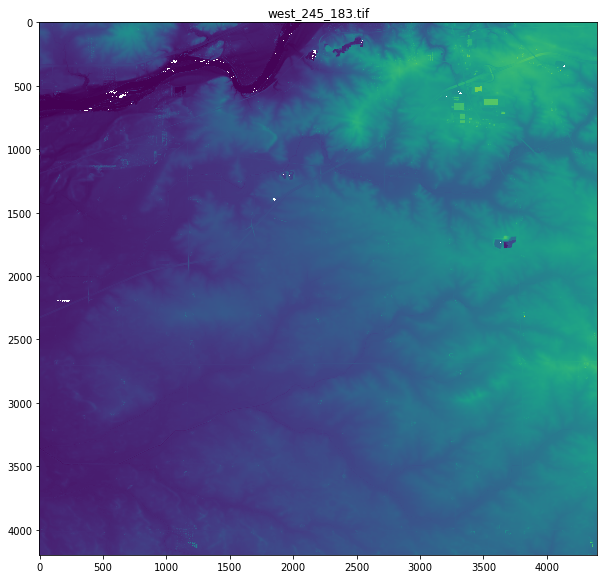

In [87]:
raster = 'west_245_183.tif'
with rio.open(raster) as img:
    arr = img.read(1, masked=True)
    print(arr.shape, arr.min(), arr.max(), ma.count_masked(arr))
    plt.figure(figsize=(10,10))
    plt.imshow(arr)
    plt.title(raster)
    plt.show()

west_245_183.tif west_245_183_filled.tif
(4198, 4399) 637.694 877.671 0


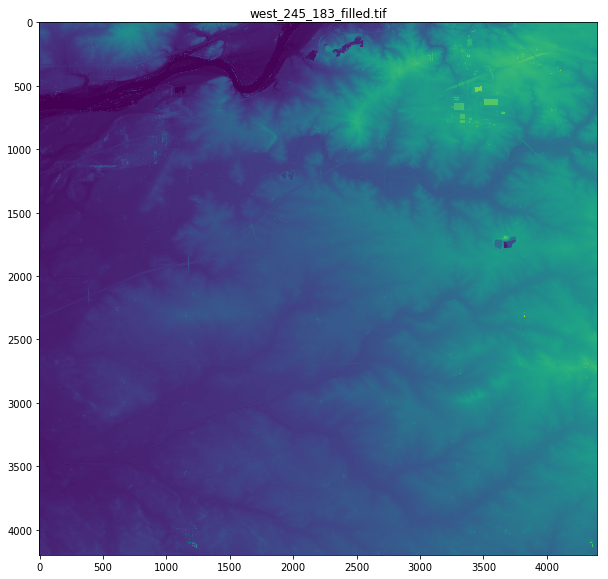

In [88]:
filled = fill_missing_data(raster)
with rio.open(filled) as img:
    arr = img.read(1, masked=True)
    print(arr.shape, arr.min(), arr.max(), ma.count_masked(arr))
    plt.figure(figsize=(10,10))
    plt.imshow(arr)
    plt.title(filled)
    plt.show()
    

In [ ]:
print(filled, 'wbt')

9.543077972266424 10.47879942829919


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


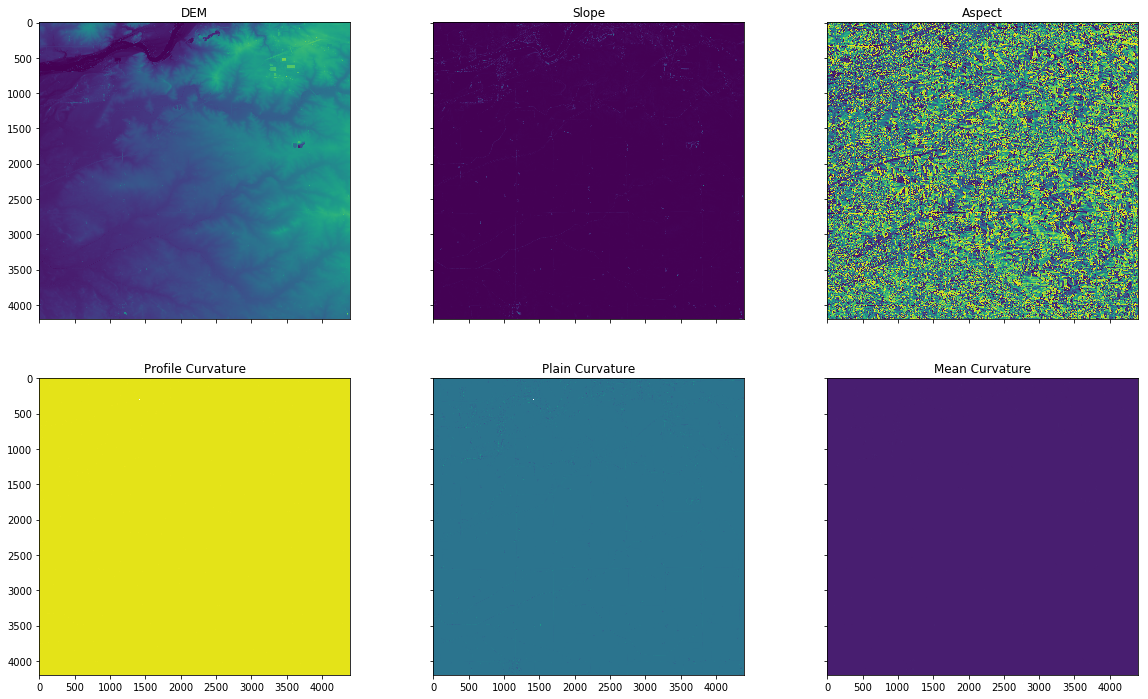

In [89]:
ta = terrain_analysis(arr, (10 * arr.shape[0], 10 * arr.shape[1]))
fig, axs = plt.subplots(2,3, figsize=(20,12))
titles = ['DEM', 'Slope', 'Aspect', 'Profile Curvature', 'Plain Curvature', 'Mean Curvature']
idx = 0
for ax in fig.get_axes():
    ax.label_outer()
    ax.set_title(titles[idx])
    ax.imshow(ta[idx,:,:])
    idx += 1
plt.show()

In [108]:
print(np.nanmin(ta[1,:,:]), np.nanmax(ta[1,:,:]))
print(np.nanmin(ta[2,:,:]), np.nanmax(ta[2,:,:]))
print(np.nanmin(ta[3,:,:]), np.nanmax(ta[3,:,:]))
print(np.nanmin(ta[4,:,:]), np.nanmax(ta[4,:,:]))
print(np.nanmin(ta[5,:,:]), np.nanmax(ta[5,:,:]))

m = np.ma.masked_where(~np.isnan(ta[2,:,:]), ta[2,:,:])
m.min(),m.max()

0.0 5.72787038973
-1.57079632679 1.57079632679
-1138.16200714 46.637037754
-0.286656808618 0.45953164303
-1.72023613106 18.9149184805


(nan, nan)

(4499, 4999) 406.883 672.963 76417


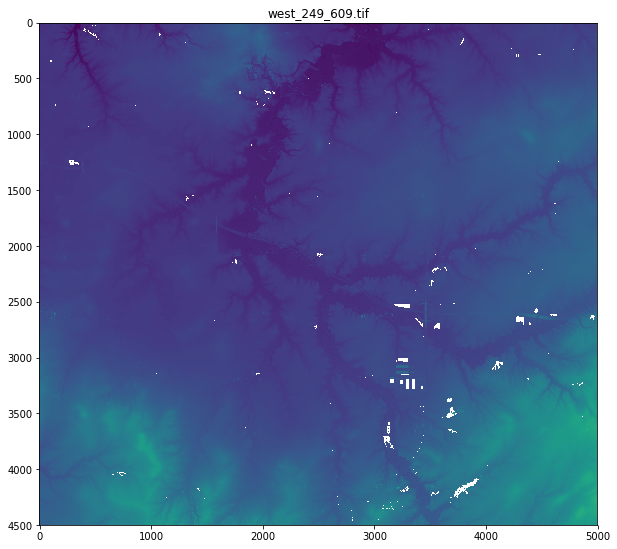

In [62]:
raster = 'west_249_609.tif'
with rio.open(raster) as img:
    arr = img.read(1, masked=True)
    print(arr.shape, arr.min(), arr.max(), ma.count_masked(arr))
    plt.figure(figsize=(10,10))
    plt.imshow(arr)
    plt.title(raster)
    plt.show()

west_249_609.tif west_249_609_filled.tif
(4499, 4999) 406.883 672.963 967


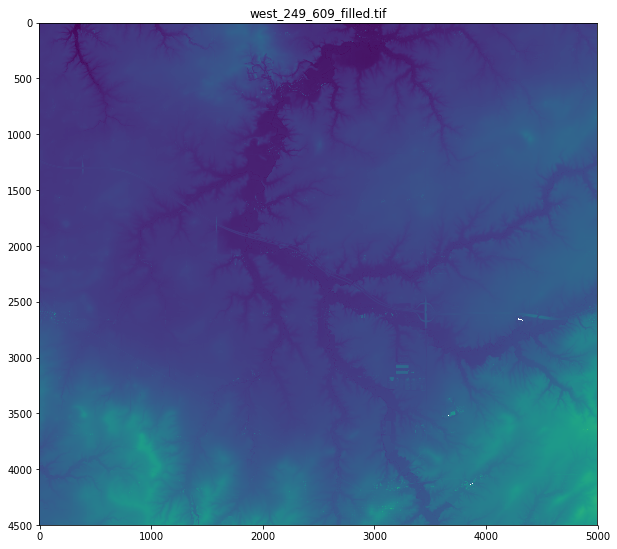

In [64]:
filled = fill_missing_data(raster, filter_size=15)
with rio.open(filled) as img:
    arr = img.read(1, masked=True)
    print(arr.shape, arr.min(), arr.max(), ma.count_masked(arr))
    plt.figure(figsize=(10,10))
    plt.imshow(arr)
    plt.title(filled)
    plt.show()

(4398, 4398) 604.538 823.984 407817


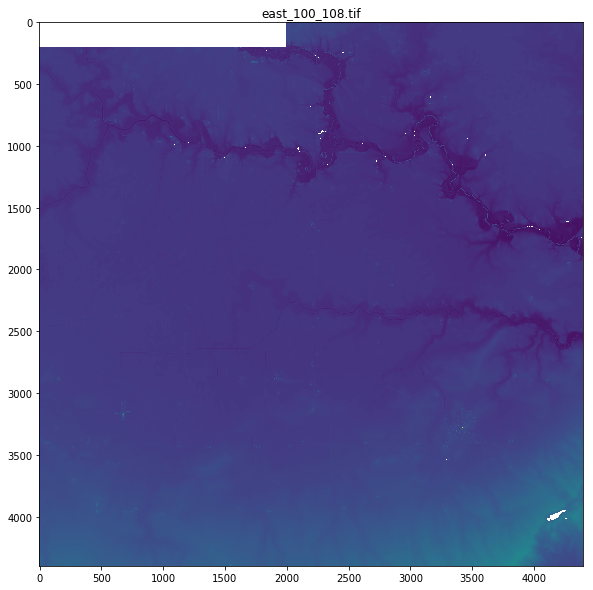

In [65]:
raster = 'east_100_108.tif'
with rio.open(raster) as img:
    arr = img.read(1, masked=True)
    print(arr.shape, arr.min(), arr.max(), ma.count_masked(arr))
    plt.figure(figsize=(10,10))
    plt.imshow(arr)
    plt.title(raster)
    plt.show()

east_100_108.tif east_100_108_filled.tif
(4398, 4398) 604.538 823.984 376445


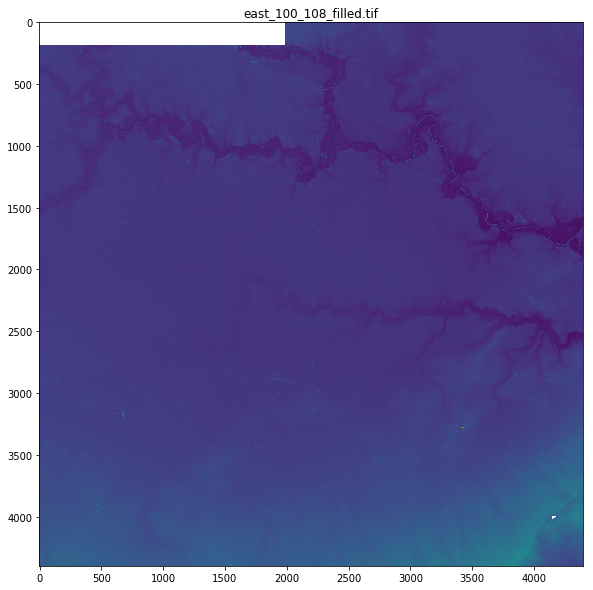

In [68]:
filled = fill_missing_data(raster, filter_size=11)
with rio.open(filled) as img:
    arr = img.read(1, masked=True)
    print(arr.shape, arr.min(), arr.max(), ma.count_masked(arr))
    plt.figure(figsize=(10,10))
    plt.imshow(arr)
    plt.title(filled)
    plt.show()

10.0 10.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


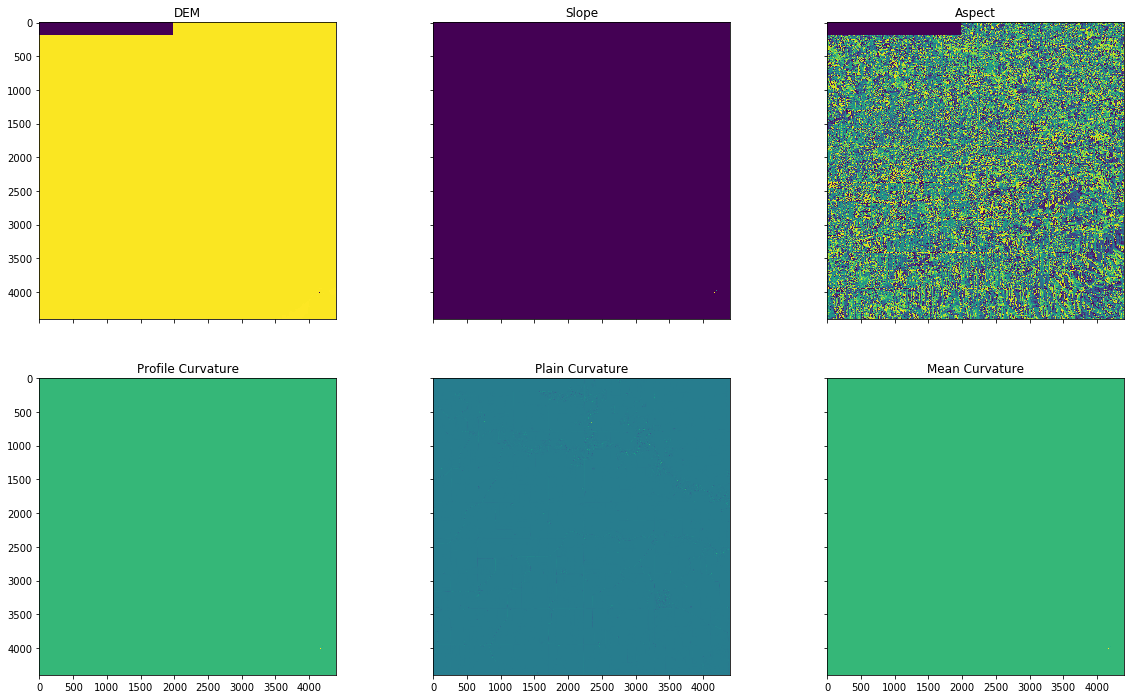

In [80]:
ta = terrain_analysis(arr, (10 * arr.shape[0], 10 * arr.shape[1]))
fig, axs = plt.subplots(2,3, figsize=(20,12))
titles = ['DEM', 'Slope', 'Aspect', 'Profile Curvature', 'Plain Curvature', 'Mean Curvature']
idx = 0
for ax in fig.get_axes():
    ax.label_outer()
    ax.set_title(titles[idx])
    ax.imshow(ta[idx,:,:])
    idx += 1
plt.show()

In [85]:
ta[1,:,:].max()

1762.8396378887273